In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.path as mpath

In [18]:
# Parameters
# ----------
Nh = 50
Nz = 100

dt = 180 # minutes
outputdt = 5 # days
runtime = 1*365 # days

locinit = "RossShelf" # Drake, Drake-upstream, Ross, coral, coral-approx, RossShelf.?
timedir = "back" # forw, back
multitimes = False # initialize at multiple different times
Nt = 12 # Number of initialized times
Dt = 6 # 5-day multiples; spacing between initialization time

# For locinit==shelf, locations are derived in calc_init_shelf.ipynb and loaded from there

# Returns
# -------
fileout = ("output"
           +".locinit_"+locinit
           +".Nh_"+str(Nh)
           +".Nz_"+str(Nz)
           +".timedir_"+timedir
           +".ntime_"+str(runtime)
           +".dt_"+str(dt))
if multitimes:
    fileout+=".itimes_N"+str(Nt)+"_D"+str(Dt)
fileout+=".nc"

ds = xr.open_dataset(fileout)

In [68]:
# grid
rootdir = '/local/data/bSOSE/iter133NEW/'
filename = 'grid.nc'
grid = xr.open_dataset(rootdir+filename)

In [19]:
ds['init_lon'] = ds['lon'].isel(obs=0)*xr.ones_like(ds['lon'])
ds['init_lat'] = ds['lat'].isel(obs=0)*xr.ones_like(ds['lat'])
ds['init_z'] = ds['z'].isel(obs=0)*xr.ones_like(ds['z'])
ds['init_T'] = ds['T'].isel(obs=0)*xr.ones_like(ds['T'])
ds['init_S'] = ds['S'].isel(obs=0)*xr.ones_like(ds['S'])

In [20]:
path = "../../data/RossShelf.level1000.sep500.maxd5000.txt"
init = np.loadtxt(path)

### Pathway count

In [81]:
res = 0.1
lonG = np.arange(140,300,res)
latG = np.arange(-80,-55,res)

In [94]:
# Separately histogram the trajectories for each starting point
ns = len(init[0,:])
hs = xr.Dataset(coords = {'lon_bin':0.5*(lonG[1:]+lonG[:-1]),
                         'lat_bin':0.5*(latG[1:]+latG[:-1])})
for startpoint in range(ns):
    print(startpoint)
    cond = (ds['init_lon']>=init[0,startpoint]-0.05) & (ds['init_lon']<=init[0,startpoint]+0.05)
    dsnow = ds.where(cond,drop=True)
    
    tmp = histogram(dsnow['lon'],dsnow['lat'],bins=[lonG,latG],block_size=1)
    hs[startpoint] = tmp.where((tmp!=0))

0
1
2
3
4
5
6
7
8
9


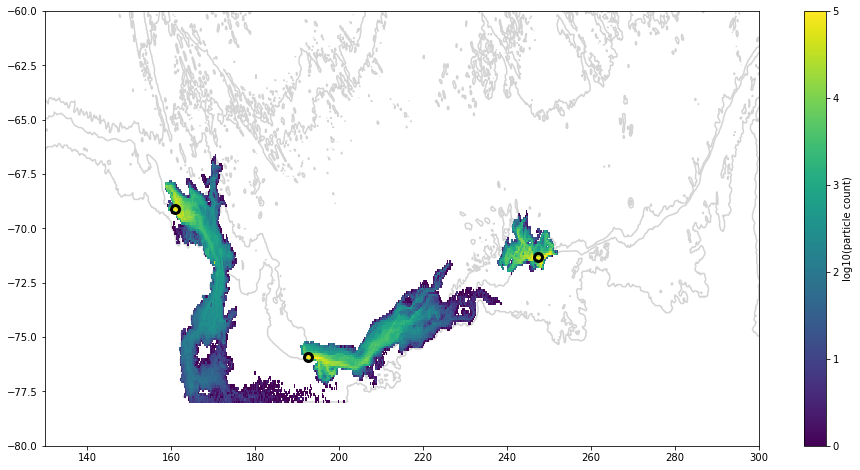

In [127]:
fig,ax = plt.subplots(figsize=(16,8))
ax.contour(grid['XC'],grid['YC'],grid['Depth'],levels=[0,1000,3000,5000],colors='lightgrey')
initptskw = dict(marker='o',markerfacecolor="None",markeredgecolor='k',markersize=8,markeredgewidth=3,zorder=20)
heatmapkw = dict(shading='auto',zorder=10,vmin=0,vmax=5,cmap='viridis')
startpoint = 0
ax.plot(init[0,startpoint],init[1,startpoint],**initptskw)
im = ax.pcolormesh(hs['lon_bin'],hs['lat_bin'],np.log10(hs[startpoint]).transpose(),**heatmapkw)
startpoint = 4
ax.plot(init[0,startpoint],init[1,startpoint],**initptskw)
ax.pcolormesh(hs['lon_bin'],hs['lat_bin'],np.log10(hs[startpoint]).transpose(),**heatmapkw)
startpoint = 8
ax.plot(init[0,startpoint],init[1,startpoint],**initptskw)
ax.pcolormesh(hs['lon_bin'],hs['lat_bin'],np.log10(hs[startpoint]).transpose(),**heatmapkw)
ax.set_xlim([130,300])
ax.set_ylim([-80,-60])
cb = plt.colorbar(im,ax=ax)
cb.set_label('log10(particle count)')